In [1]:
#My dependencies
import requests
import pandas as pd
from census import Census
from api_keys_JT import census_api_key
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from scipy.stats import stats
from unidecode import unidecode
import re

In [2]:
#Years to loop through 
years = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
dsource = 'acs'
dname = 'acs1'
# Data columns to fetch
cols = 'NAME,B25077_001E,B25058_001E,B15003_022E,B01003_001E,B23025_004E,B17001_002E,B23025_003E,B19013_001E'  
# List of all state FIPS codes

state_fips_codes = ['01', '02', '04', '05', '06', '08', '09', '10', '11', '12', '13', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29',
    '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '44', '45', '46', '47', '48', '49', '50', '51', '53', '54', '55', '56', '72']  

# Initialize an empty DataFrame to collect data
all_data = []

# Loop through each year
for year in years:
    
    # Loop through all states to fetch data for all counties
    for state in state_fips_codes:
        # Construct the data URL for querying each state and its counties for the current year
        data_url = f'https://api.census.gov/data/{year}/{dsource}/{dname}?get={cols}&for=county:*&in=state:{state}'

        # Send the GET request to the Census API
        response = requests.get(data_url)

        # Check if the request was successful (200 indicates request was successfully processed)
        if response.status_code == 200:
            # Parse the response JSON data
            data = response.json()
            
            # Create a DataFrame from the response data
            df = pd.DataFrame(data[1:], columns=data[0])  # Skip the header row
            
            # Rename columns
            df = df.rename(columns={
                'NAME': 'County Name',
                'state': 'State FIPS',
                'county': 'County FIPS',
                'B25077_001E': 'Median House Price ($)',
                'B25058_001E': 'Median Rent ($)',
                'B01003_001E': 'Total Population',
                'B15003_022E': 'Population with Bachelor\'s Degree',
                'B23025_004E': 'Number of Employed People',
                'B17001_002E': 'People with Income Below Poverty',
                'B23025_003E': 'Total Labor Force',
                'B19013_001E' : 'Median Household Income ($)'
            })
            
            # Add a column for the year
            df['Year'] = year
            
            # Append the data for this year and state to the list
            all_data.append(df)
        else:
            print(f"Error: {response.status_code} for State: {state} in Year: {year}")

# Concatenate all data into a single DataFrame
final_data_df = pd.concat(all_data, ignore_index=True)




In [3]:

# Convert columns to numeric, errors='coerce' will turn invalid values into NaN
numeric_columns = [
    'Median House Price ($)', 'Median Rent ($)', 'Total Population',
    'Population with Bachelor\'s Degree', 'Number of Employed People',
    'People with Income Below Poverty', 'Total Labor Force', 'Median Household Income ($)'
]

# Convert all columns to numeric
for col in numeric_columns:
    final_data_df[col] = pd.to_numeric(final_data_df[col], errors='coerce')

# Now print the min and max values, ignoring NaNs
print('Minimum Values:')
print(final_data_df.min())
print('---------------------------------------------------')
print('Maximum Values:')
print(final_data_df.max())

clean_data_df = final_data_df.dropna()

# Check for missing values and data types
print('Number of Null Values in Each Column:')
print(clean_data_df.isnull().sum())

# Removes Non-ASCII Characters
clean_data_df['County Name Cleaned'] = df['County Name'].apply(lambda x: unidecode(x).strip())

Minimum Values:
County Name                          Ada County, Idaho
Median House Price ($)                           49400
Median Rent ($)                                    229
Population with Bachelor's Degree               2306.0
Total Population                                 61792
Number of Employed People                        15513
People with Income Below Poverty                1432.0
Total Labor Force                                19658
Median Household Income ($)                      11940
State FIPS                                          01
County FIPS                                        001
Year                                              2011
dtype: object
---------------------------------------------------
Maximum Values:
County Name                          Yuma County, Arizona
Median House Price ($)                            1233600
Median Rent ($)                                      2415
Population with Bachelor's Degree               1551191.0
Total Popu

C:\Users\jitra\AppData\Local\Temp\ipykernel_21124\1615202530.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_df['County Name Cleaned'] = df['County Name'].apply(lambda x: unidecode(x).strip())


In [4]:
clean_data_df.to_csv('census_data_all.csv', index=False)

In [5]:
clean_data_df['Annual Rent-to-Price Ratio'] = ((clean_data_df['Median Rent ($)']*12) / clean_data_df ['Median House Price ($)']) * 100
clean_data_df['Employment Rate %'] = (clean_data_df['Number of Employed People'] / clean_data_df['Total Labor Force']) * 100
clean_data_df['% People Living in Poverty'] = (clean_data_df['People with Income Below Poverty'] / clean_data_df['Total Population']) * 100
clean_data_df['% Pop. Bachelors Degree'] = clean_data_df['Population with Bachelor\'s Degree'] / clean_data_df['Total Population'] * 100

clean_data_df

C:\Users\jitra\AppData\Local\Temp\ipykernel_21124\999656447.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_df['Annual Rent-to-Price Ratio'] = ((clean_data_df['Median Rent ($)']*12) / clean_data_df ['Median House Price ($)']) * 100
C:\Users\jitra\AppData\Local\Temp\ipykernel_21124\999656447.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_df['Employment Rate %'] = (clean_data_df['Number of Employed People'] / clean_data_df['Total Labor Force']) * 100
C:\Users\jitra\AppData\Local

,County Name,Median House Price ($),Median Rent ($),Population with Bachelor's Degree,Total Population,Number of Employed People,People with Income Below Poverty,Total Labor Force,Median Household Income ($),State FIPS,County FIPS,Year,County Name Cleaned,Annual Rent-to-Price Ratio,Employment Rate %,% People Living in Poverty,% Pop. Bachelors Degree
0,"Baldwin County, Alabama",170300,679,24157.0,186717,85257,24221.0,93619,50900,01,003,2011,"Arecibo Municipio, Puerto Rico",4.784498,91.068052,12.972038,12.937761
1,"Calhoun County, Alabama",99100,416,7750.0,117797,47363,24341.0,54373,39037,01,015,2011,"Carolina Municipio, Puerto Rico",5.037336,87.107572,20.663514,6.579115
2,"Cullman County, Alabama",112000,410,4878.0,80536,32689,14740.0,36250,40054,01,043,2011,"Trujillo Alto Municipio, Puerto Rico",4.392857,90.176552,18.302374,6.056919
3,"DeKalb County, Alabama",97100,361,2465.0,71375,29227,13193.0,33281,36541,01,049,2011,"Bayamon Municipio, Puerto Rico",4.461380,87.818876,18.484063,3.453590
4,"Elmore County, Alabama",148900,479,8339.0,80162,33862,9749.0,38020,57405,01,051,2011,"Ponce Municipio, Puerto Rico",3.860309,89.063651,12.161623,10.402685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7474,"Toa Baja Municipio, Puerto Rico",111100,478,10751.0,74271,27886,28367.0,31768,23368,72,137,2019,NaN,5.162916,87.780156,38.193911,14.475367
7475,"Caguas Municipio, Puerto Rico",124500,463,20932.0,124606,47132,47851.0,52224,24507,72,025,2019,NaN,4.462651,90.249694,38.401843,16.798549
7476,"San Juan Municipio, Puerto Rico",151700,438,55716.0,318441,116362,124927.0,141555,23005,72,127,2019,NaN,3.464733,82.202677,39.230815,17.496491
7477,"Guaynabo Municipio, Puerto Rico",174700,532,18127.0,83728,35993,19101.0,39237,37499,72,061,2019,NaN,3.654264,91.732293,22.813157,21.649866


In [6]:
#GROUPING ALL DATA BY COUNTIES
#To ensure exact matches, we need to group by all State FIPS, County FIPS, and County Name.
#This is because countys in different states may have the same name.
clean_data_df['Combined FIPS'] = clean_data_df['County FIPS'] + clean_data_df['State FIPS']

grouped_df = clean_data_df.groupby(['County Name', 'Combined FIPS'])
grouped_df.head()



C:\Users\jitra\AppData\Local\Temp\ipykernel_21124\362565594.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_df['Combined FIPS'] = clean_data_df['County FIPS'] + clean_data_df['State FIPS']


,County Name,Median House Price ($),Median Rent ($),Population with Bachelor's Degree,Total Population,Number of Employed People,People with Income Below Poverty,Total Labor Force,Median Household Income ($),State FIPS,County FIPS,Year,County Name Cleaned,Annual Rent-to-Price Ratio,Employment Rate %,% People Living in Poverty,% Pop. Bachelors Degree,Combined FIPS
0,"Baldwin County, Alabama",170300,679,24157.0,186717,85257,24221.0,93619,50900,01,003,2011,"Arecibo Municipio, Puerto Rico",4.784498,91.068052,12.972038,12.937761,00301
1,"Calhoun County, Alabama",99100,416,7750.0,117797,47363,24341.0,54373,39037,01,015,2011,"Carolina Municipio, Puerto Rico",5.037336,87.107572,20.663514,6.579115,01501
2,"Cullman County, Alabama",112000,410,4878.0,80536,32689,14740.0,36250,40054,01,043,2011,"Trujillo Alto Municipio, Puerto Rico",4.392857,90.176552,18.302374,6.056919,04301
3,"DeKalb County, Alabama",97100,361,2465.0,71375,29227,13193.0,33281,36541,01,049,2011,"Bayamon Municipio, Puerto Rico",4.461380,87.818876,18.484063,3.453590,04901
4,"Elmore County, Alabama",148900,479,8339.0,80162,33862,9749.0,38020,57405,01,051,2011,"Ponce Municipio, Puerto Rico",3.860309,89.063651,12.161623,10.402685,05101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7151,"Franklin County, North Carolina",172700,633,8029.0,69685,33272,6025.0,36169,57099,37,069,2019,NaN,4.398379,91.990379,8.646050,11.521848,06937
7197,"Athens County, Ohio",145400,724,6432.0,65327,28943,15275.0,31442,41851,39,009,2019,NaN,5.975241,92.052032,23.382369,9.845852,00939
7288,"Kershaw County, South Carolina",146800,545,7227.0,66551,29374,9448.0,30909,55198,45,055,2019,NaN,4.455041,95.033809,14.196631,10.859341,05545
7344,"Wise County, Texas",243500,719,5985.0,69984,34650,3662.0,35396,71421,48,497,2019,NaN,3.543326,97.892417,5.232625,8.551955,49748


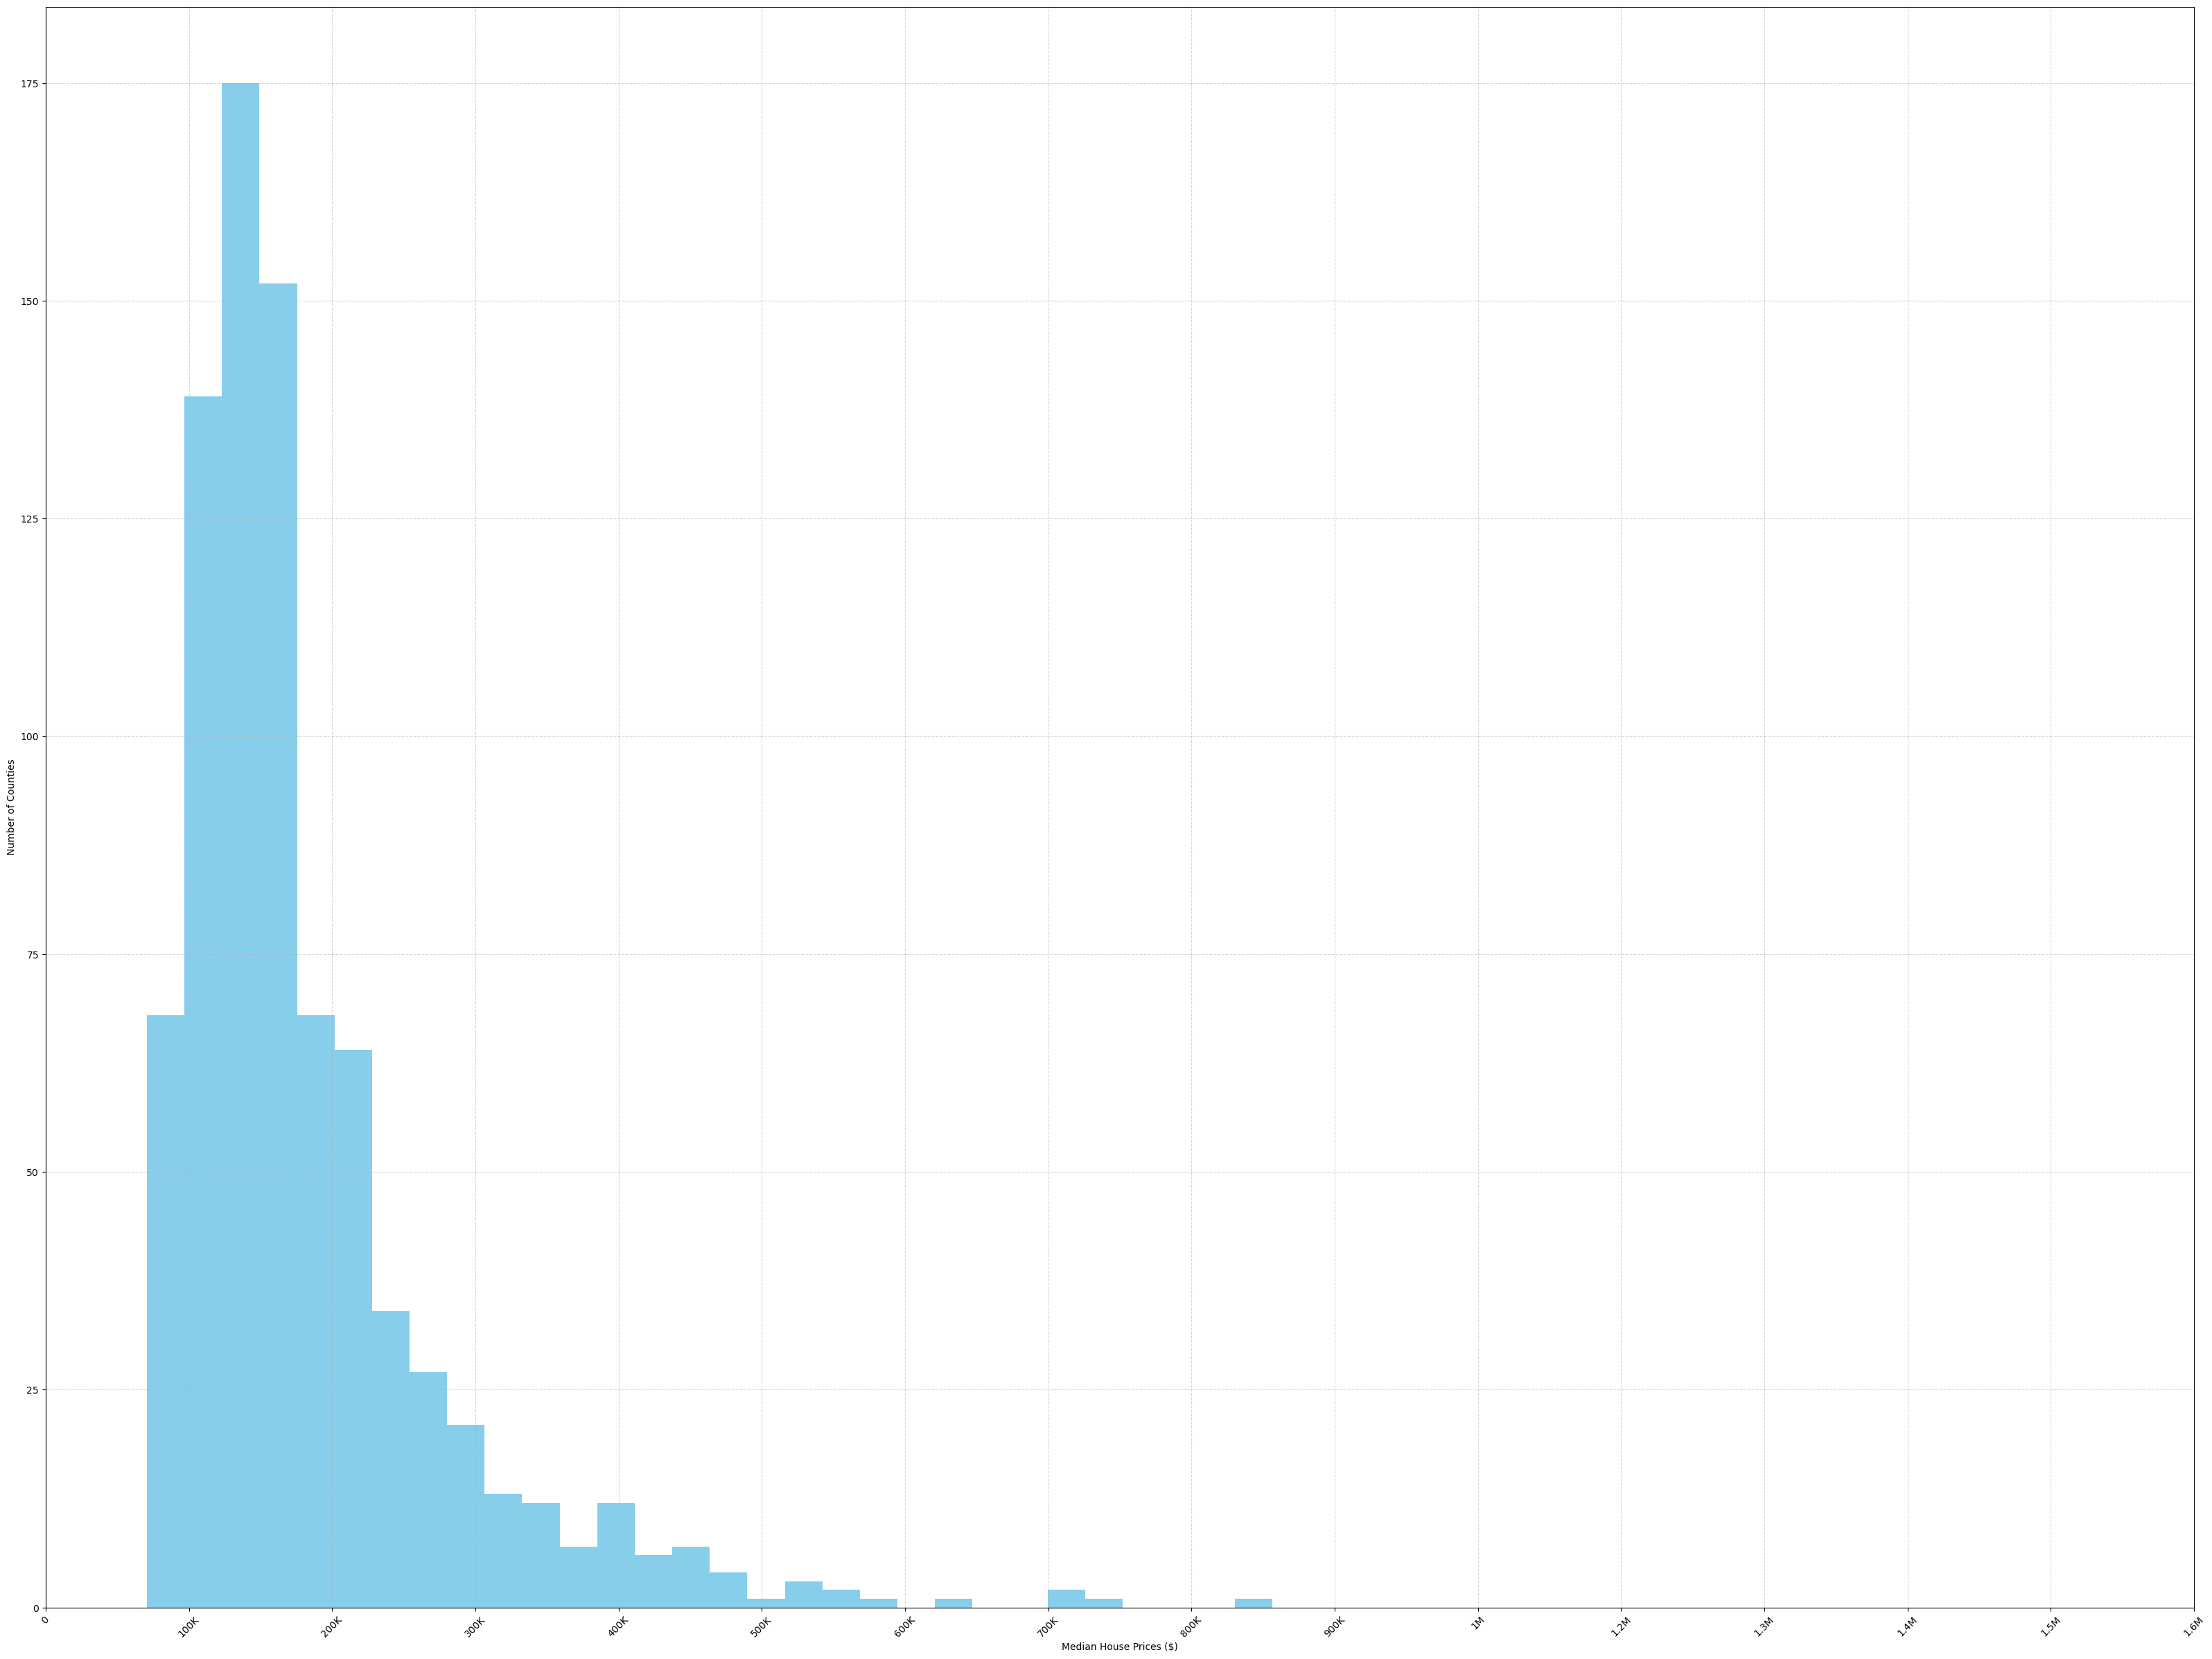

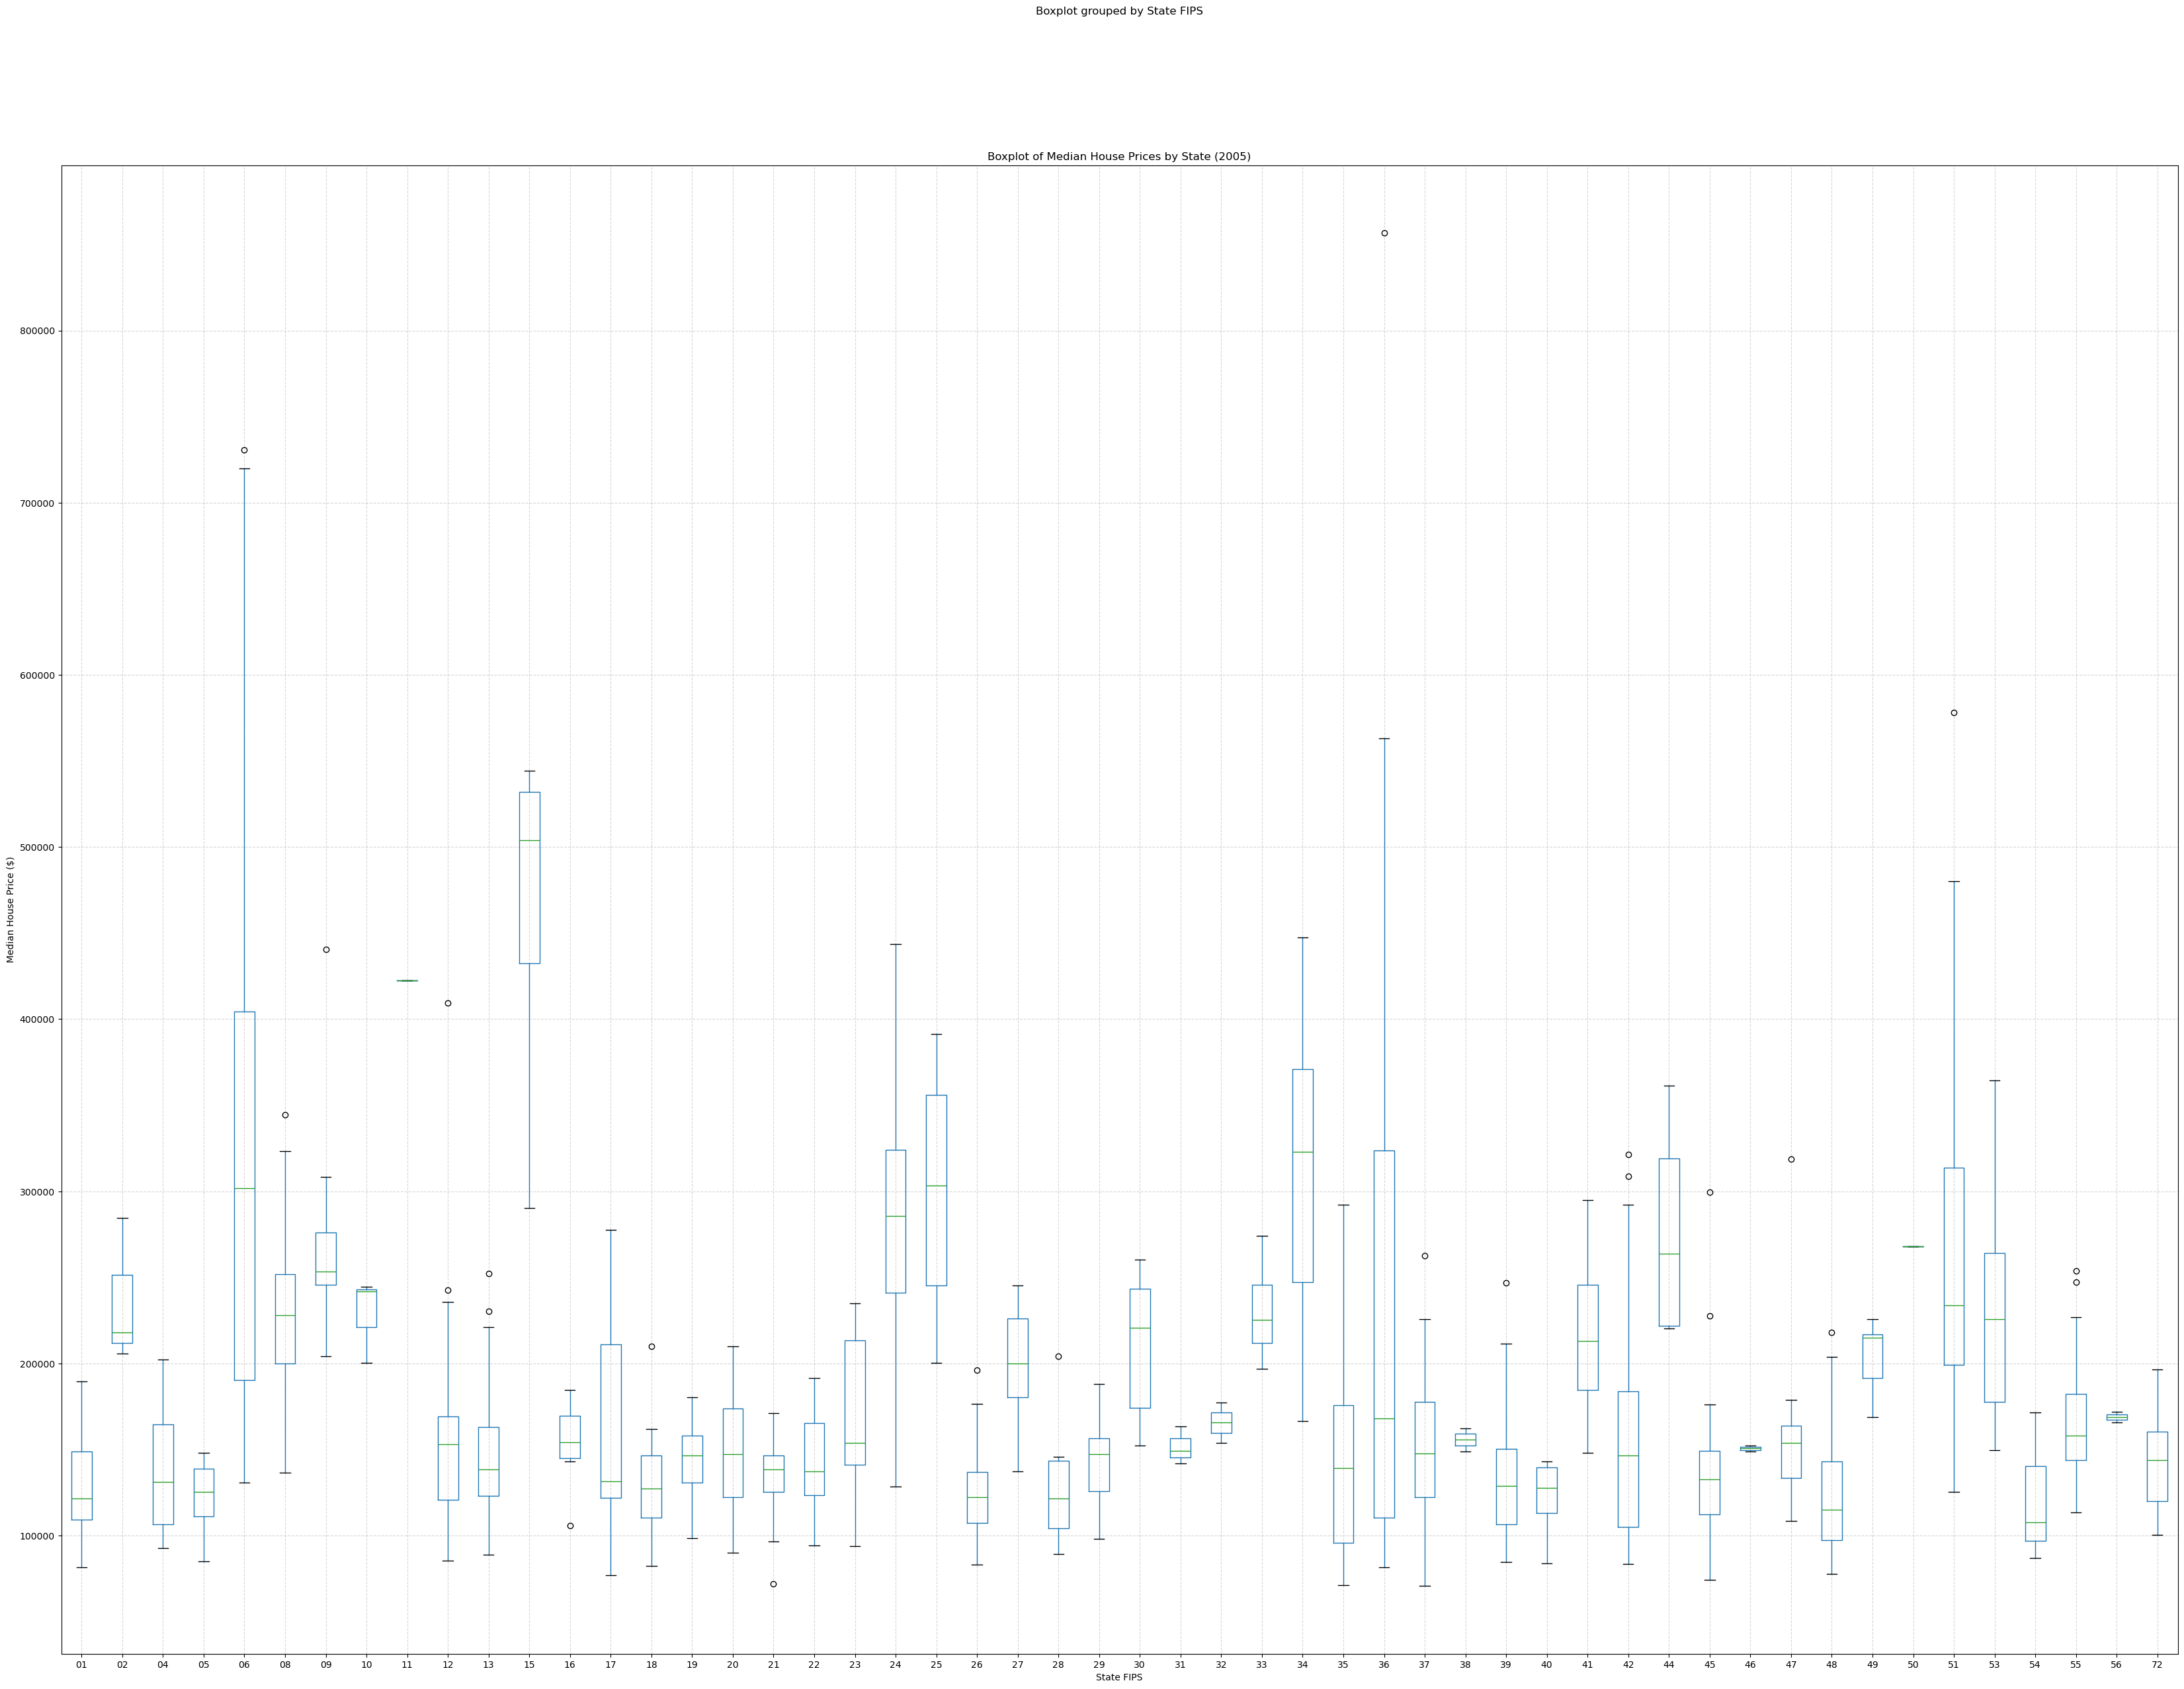

In [9]:
# Taking a look at house prices
#House Prices: Are the median prices increasing, decreasing, or remaining stable over time?
#Has the variability in house prices increased, indicating greater disparity?
#Are there any specific regions where house prices significantly outpace income growth?
#What is the impact of employment shocks on house prices?

plt.figure(figsize=(40,30))
first_year_data = clean_data_df.loc[clean_data_df['Year'] == 2011]
x_values = np.arange(len(first_year_data))
plt.hist(first_year_data["Median House Price ($)"], bins=30, color='skyblue')
plt.xticks(ticks=range(0, 1600000, 100000), labels=['0', '100K', '200K', '300K', '400K', '500K', '600K', '700K', '800K', '900K', '1M','1.2M', '1.3M', '1.4M', '1.5M', '1.6M'], rotation=45)
plt.xlabel('Median House Prices ($)')
plt.ylabel('Number of Counties')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

fig, ax = plt.subplots(figsize=(40, 30))  
first_year_data.boxplot(column='Median House Price ($)', by='State FIPS', grid=False, ax=ax)
ax.set_title('Boxplot of Median House Prices by State (2005)')
ax.set_xlabel('State FIPS')
ax.set_ylabel('Median House Price ($)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()




Plotting for mid-year - 2015

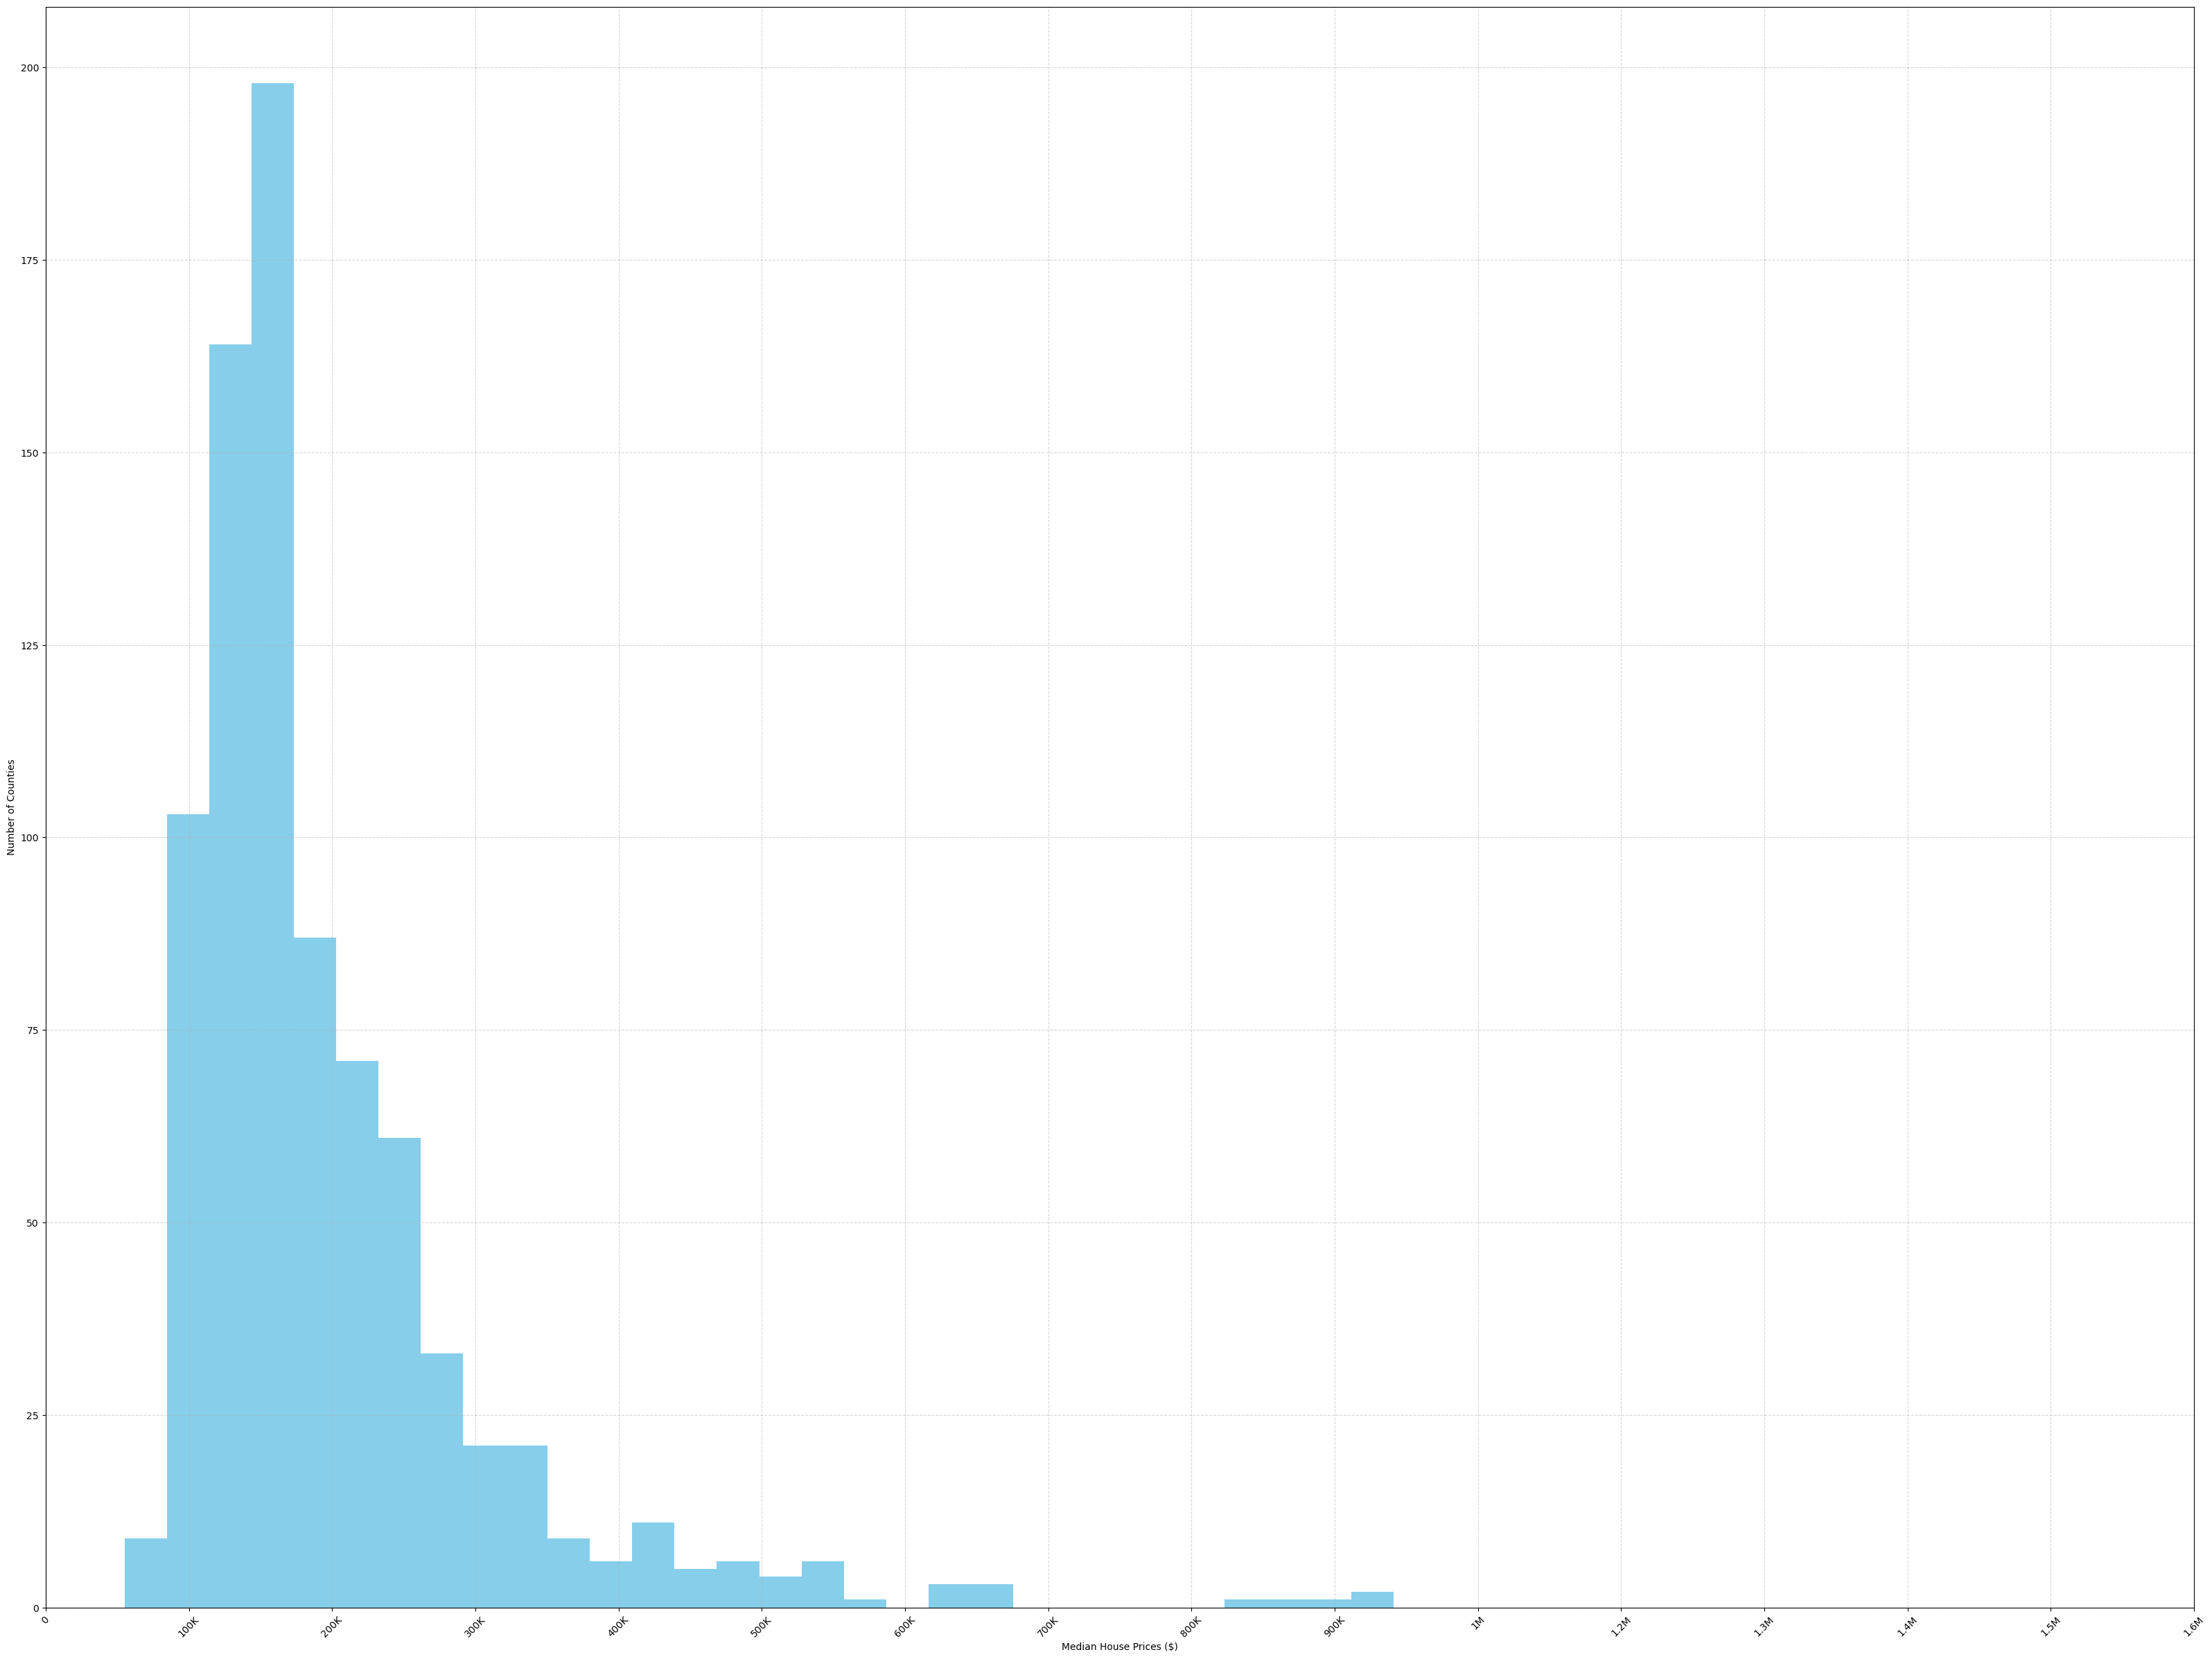

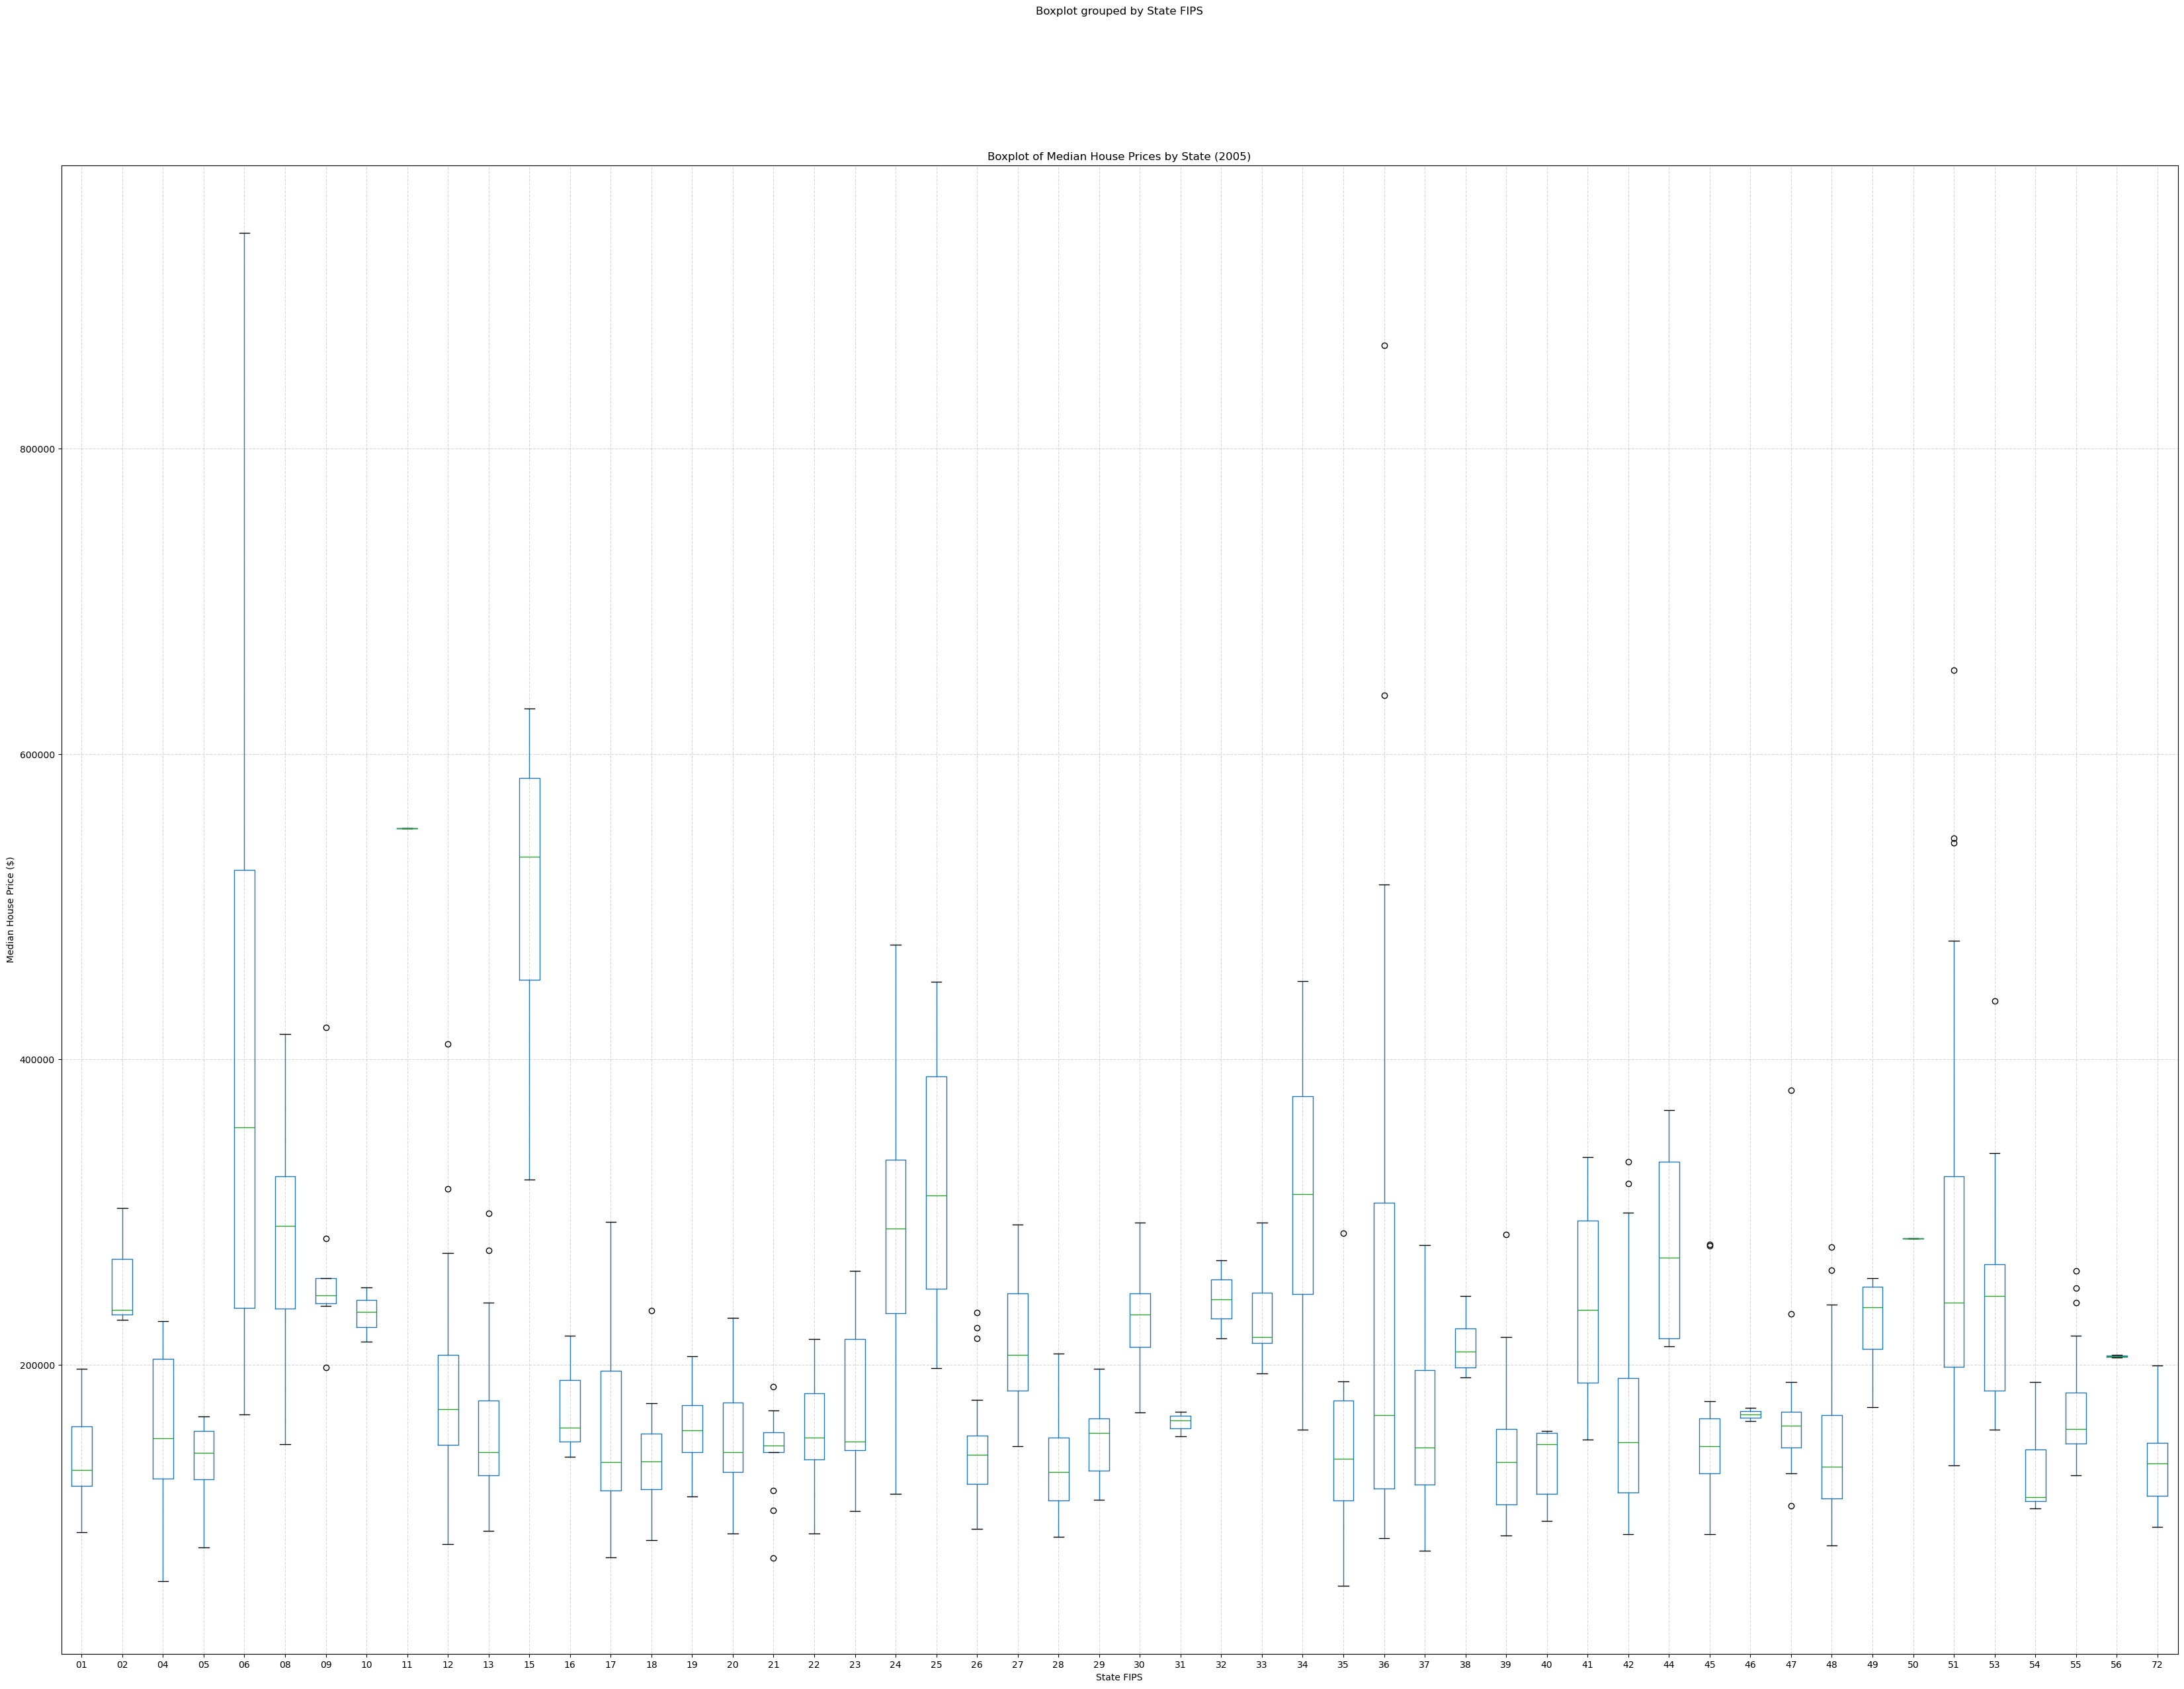

In [10]:
plt.figure(figsize=(40,30))
mid_year_data = clean_data_df.loc[clean_data_df['Year'] == 2015]
x_values = np.arange(len(mid_year_data))
plt.hist(mid_year_data["Median House Price ($)"], bins=30, color='skyblue')
plt.xticks(ticks=range(0, 1600000, 100000), labels=['0', '100K', '200K', '300K', '400K', '500K', '600K', '700K', '800K', '900K', '1M','1.2M', '1.3M', '1.4M', '1.5M', '1.6M'], rotation=45)
plt.xlabel('Median House Prices ($)')
plt.ylabel('Number of Counties')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

fig, ax = plt.subplots(figsize=(40, 30))  
mid_year_data.boxplot(column='Median House Price ($)', by='State FIPS', grid=False, ax=ax)
ax.set_title('Boxplot of Median House Prices by State (2005)')
ax.set_xlabel('State FIPS')
ax.set_ylabel('Median House Price ($)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Final Year plots - 2019


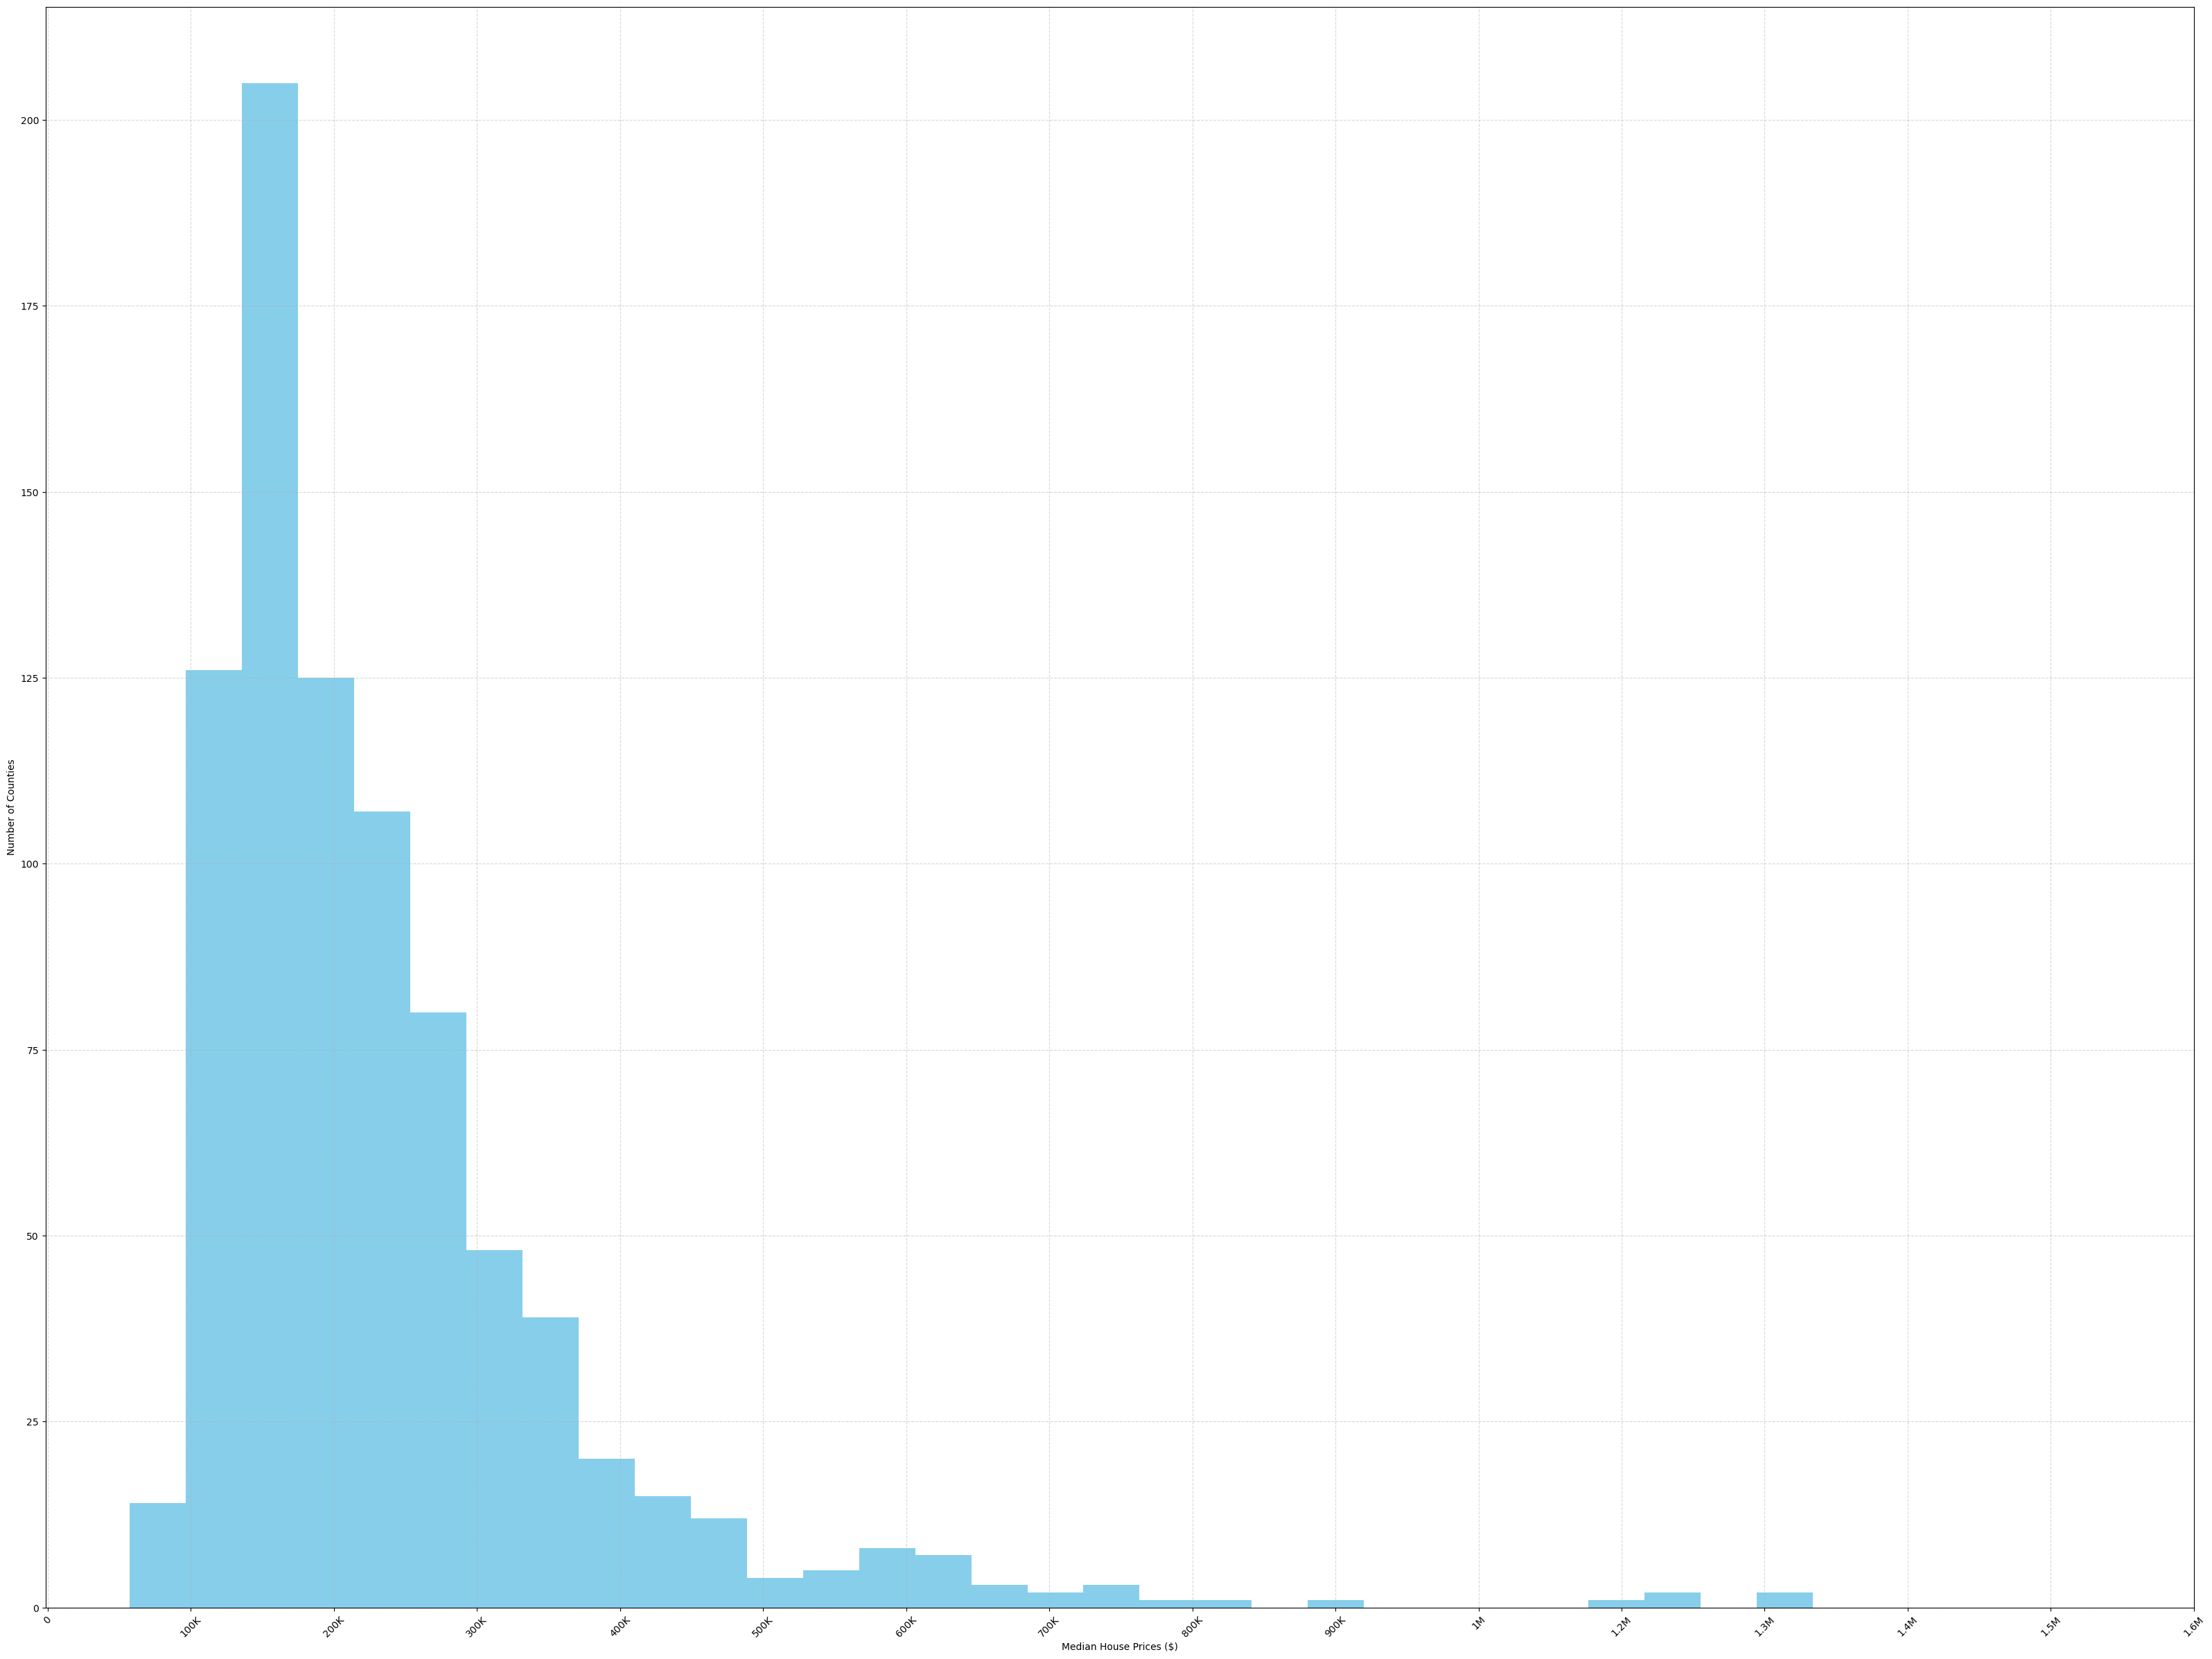

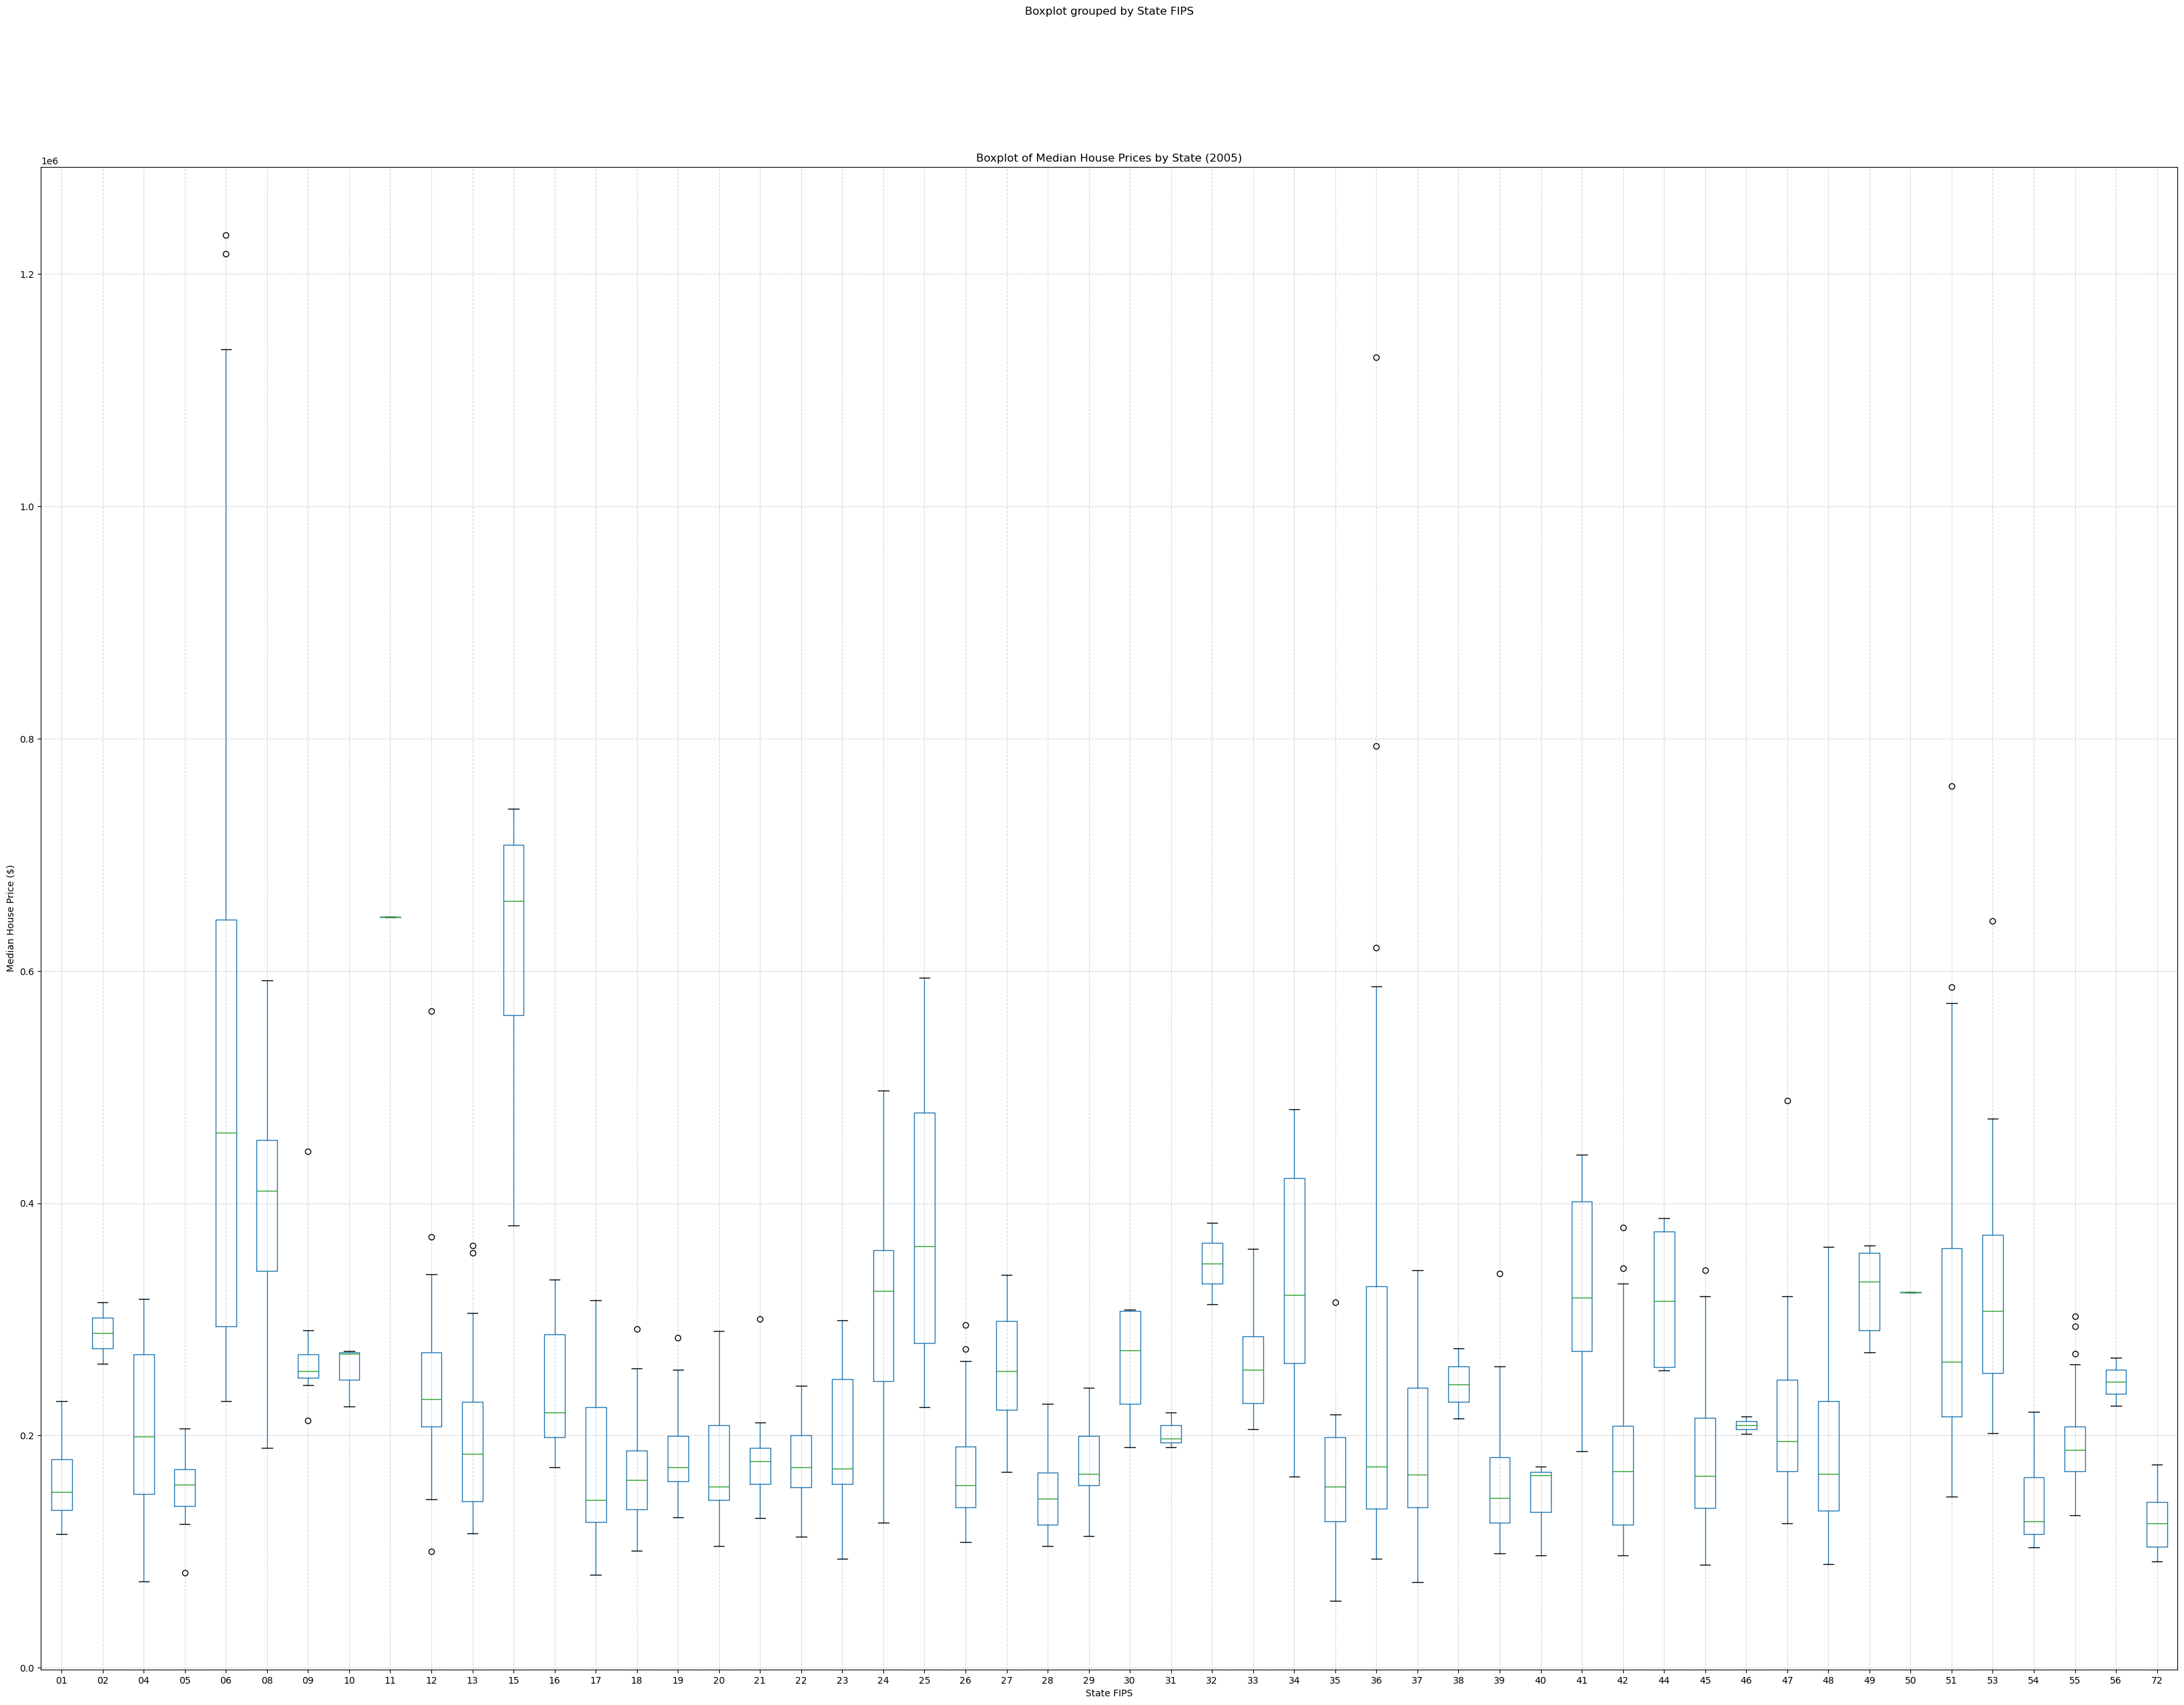

200645.73653820332


In [12]:
plt.figure(figsize=(40,30))
last_year_data = clean_data_df.loc[clean_data_df['Year'] == 2019]
x_values = np.arange(len(last_year_data))
plt.hist(last_year_data["Median House Price ($)"], bins=30, color='skyblue')
plt.xticks(ticks=range(0, 1600000, 100000), labels=['0', '100K', '200K', '300K', '400K', '500K', '600K', '700K', '800K', '900K', '1M','1.2M', '1.3M', '1.4M', '1.5M', '1.6M'], rotation=45)
plt.xlabel('Median House Prices ($)')
plt.ylabel('Number of Counties')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

fig, ax = plt.subplots(figsize=(40, 30))  
last_year_data.boxplot(column='Median House Price ($)', by='State FIPS', grid=False, ax=ax)
ax.set_title('Boxplot of Median House Prices by State (2005)')
ax.set_xlabel('State FIPS')
ax.set_ylabel('Median House Price ($)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

print(clean_data_df['Median House Price ($)'].mean())

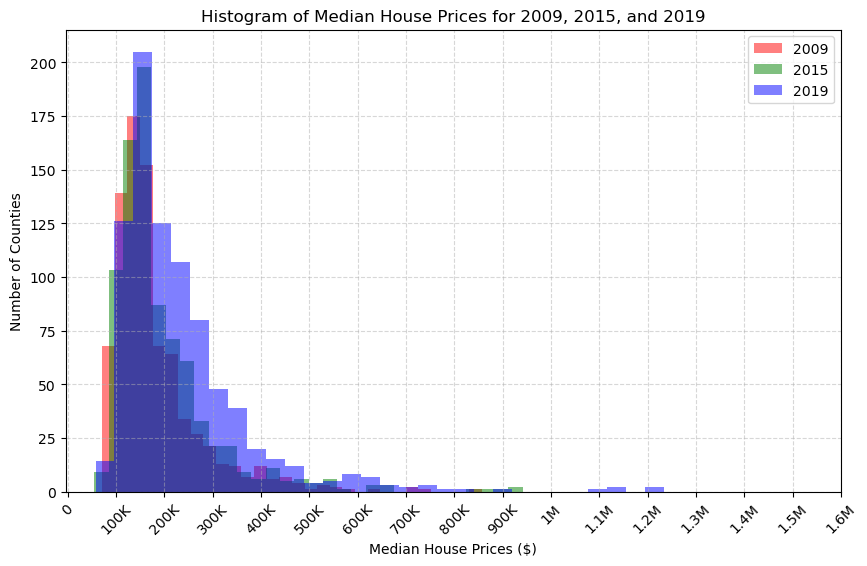

In [17]:
# Sample data for the years
data_2009 = clean_data_df.loc[clean_data_df['Year'] == 2011]["Median House Price ($)"]
data_2015 = clean_data_df.loc[clean_data_df['Year'] == 2015]["Median House Price ($)"]
data_2019 = clean_data_df.loc[clean_data_df['Year'] == 2019]["Median House Price ($)"]

# Plotting the histograms
plt.figure(figsize=(10, 6))
plt.hist(data_2009, bins=30, alpha=0.5, label='2009', color='red')
plt.hist(data_2015, bins=30, alpha=0.5, label='2015', color='green')
plt.hist(data_2019, bins=30, alpha=0.5, label='2019', color='blue')

# Adding titles and labels
plt.title('Histogram of Median House Prices for 2009, 2015, and 2019')
plt.xlabel('Median House Prices ($)')
plt.ylabel('Number of Counties')

# Define the ticks and labels
ticks = np.arange(0, 1700000, 100000)
labels = ['0', '100K', '200K', '300K', '400K', '500K', '600K', '700K', '800K', '900K', '1M', '1.1M', '1.2M', '1.3M', '1.4M', '1.5M', '1.6M']

# Set the ticks and labels
plt.xticks(ticks=ticks, labels=labels, rotation=45)

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper right')

# Display the plot
plt.show()



EDUCATIONAL ATTAINMENT AND HOME PRICES - STUDY


Question 1: How does the percentage of the population with a bachelor's degree correlate with median home prices?

---------------- Results -----------------------------------------------
The slope of 18275.45 suggests that, on average, for every 1% increase in the population with a bachelor's degree, the median house price increases by $18275.45
The correlation between these variables is 0.6323720332830076 and the R-squared is 0.3998943884784853
The negative intercept of -18959.9 suggests that this analysis is not quite valid for small house prices and in counties with near-zero bachelor degree holders
THIS WILL CHANGE - The p-value of the correlation coefficient is 0.000
THIS WILL CHANGE - We conclude that the relationship between bot variables is medium in strengh, and that at least at third of the variability in prices can be captured by educational attainment
------------------------------------------------------------------------


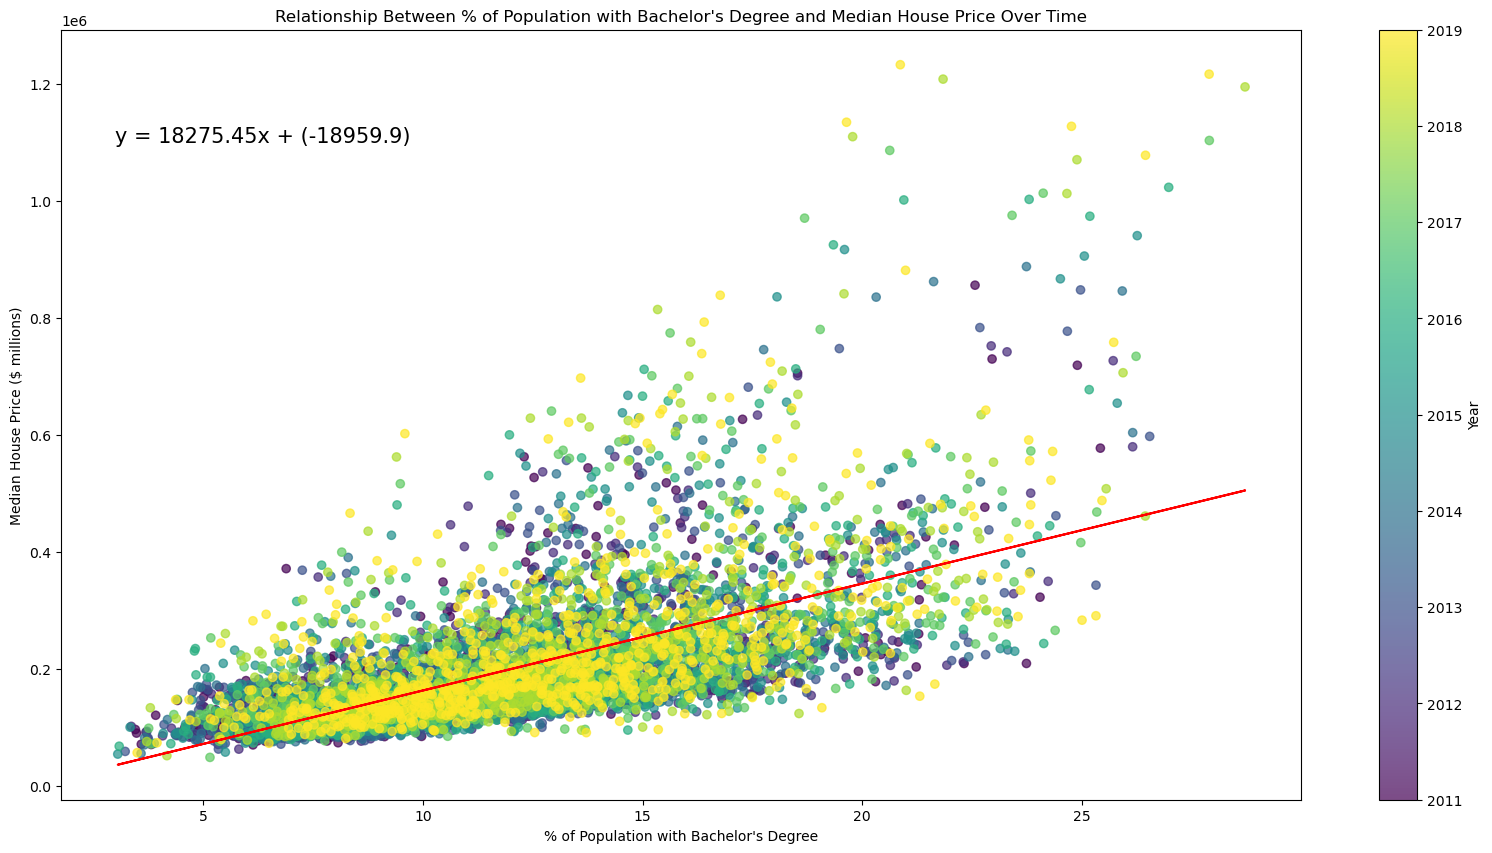

In [21]:
#LET'S SEE HOW THESE TWO RELATE.
#THIS USES ALL YEARS AND WILL CHANGE ONCE DAT IS FIXED

X = clean_data_df['% Pop. Bachelors Degree']
Y = clean_data_df['Median House Price ($)']

# Scatter plot with color-coded years
plt.figure(figsize=(20, 10))

# Use a color map to differentiate years
scatter = plt.scatter(X, 
                      Y,
                      c=clean_data_df['Year'], cmap='viridis', alpha=0.7)

# Add a color bar to show the year mapping
plt.colorbar(scatter, label='Year')

# Labels and title
plt.title('Relationship Between % of Population with Bachelor\'s Degree and Median House Price Over Time')
plt.xlabel('% of Population with Bachelor\'s Degree')
plt.ylabel('Median House Price ($ millions)')

#TAKING A FIRST LOOK, THERE SEEMS TO BE A POSITIVE RELATIONSHIP. I WILL RUN A REGRESSION, AND THEN CONTROL FOR THE OUTLIERS TO SEE IF THE RELATIONSHIP PERSISTS, IF THERE IS ONE. 

(slope, intercept, rvalue, pvalue, stderr) = linregress(X, Y)
regress_values = X * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + (" +str(round(intercept,2))+ ")"
plt.plot(X,regress_values,"r-")
plt.annotate(line_eq, (3, 1100000),size=15)

print('---------------- Results -----------------------------------------------')
print(f'The slope of {slope:.2f} suggests that, on average, for every 1% increase in the population with a bachelor\'s degree, the median house price increases by ${slope:.2f}')
print(f'The correlation between these variables is {rvalue} and the R-squared is {(rvalue**2)}')
print(f'The negative intercept of {round(intercept, 2)} suggests that this analysis is not quite valid for small house prices and in counties with near-zero bachelor degree holders')
print(f'THIS WILL CHANGE - The p-value of the correlation coefficient is {pvalue:.3f}')
print(f'THIS WILL CHANGE - We conclude that the relationship between bot variables is medium in strengh, and that at least at third of the variability in prices can be captured by educational attainment')
print('------------------------------------------------------------------------')

QUESTION 2 - ARE MEDIAN HOUSE PRICES HIGHER IN COUNTIES WITH A HIGHER PROPORTION OF BACHELOR'S DEGREE HOLDERS?

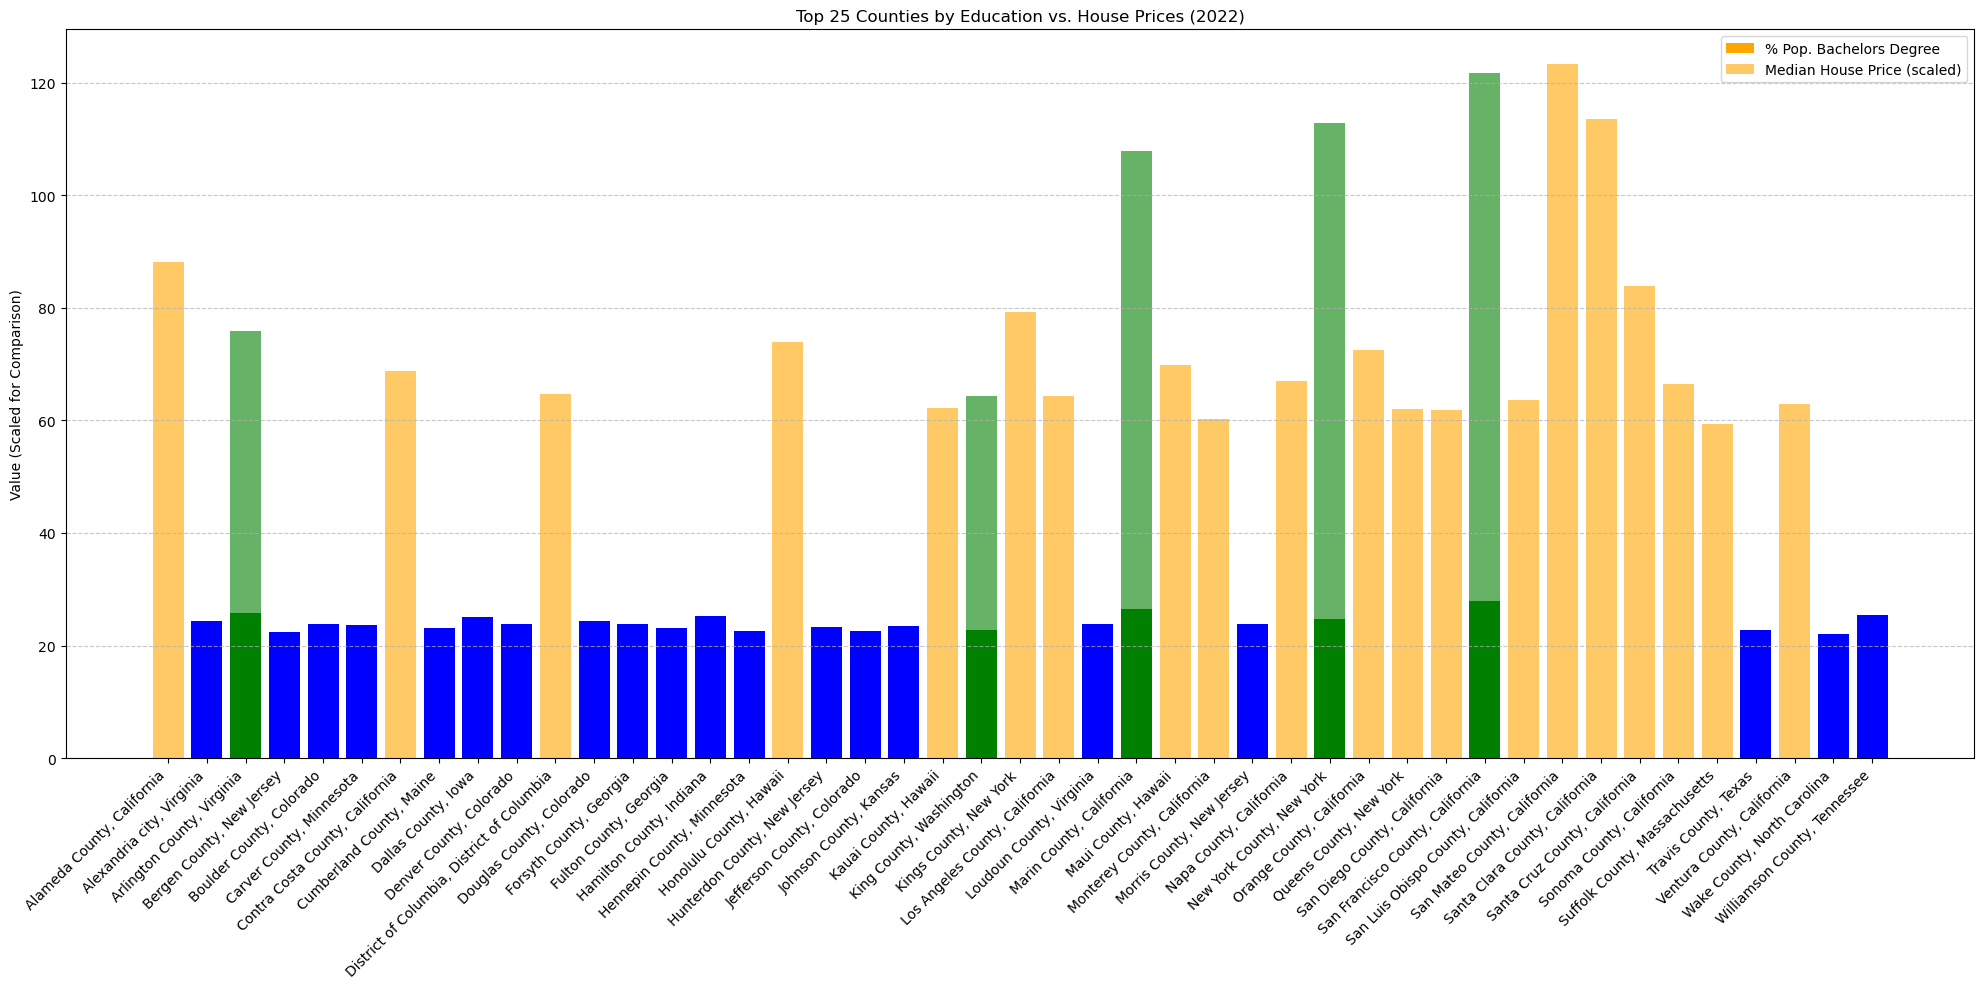

In [25]:
#LET'S ANALYZE ONE YEAR FIRST
# Filter for a single year (e.g., 2022)
selected_year_data = clean_data_df[clean_data_df['Year'] == 2019]

# Top 10 counties by educational attainment
top_edu = selected_year_data.nlargest(25, '% Pop. Bachelors Degree')[['County Name', '% Pop. Bachelors Degree']].copy()
top_edu['List'] = 'Top Edu'

# Top 10 counties by median house price
top_price = selected_year_data.nlargest(25, 'Median House Price ($)')[['County Name', 'Median House Price ($)']].copy()
top_price['List'] = 'Top Price'

# Merge the two lists to find overlaps
merged_top = pd.merge(top_edu, top_price, on='County Name', how='outer', indicator=True)

# Visualize overlap
plt.figure(figsize=(20, 10))
colors = merged_top['_merge'].map({'both': 'green', 'left_only': 'blue', 'right_only': 'orange'})
plt.bar(merged_top['County Name'], merged_top['% Pop. Bachelors Degree'], color=colors, label='% Pop. Bachelors Degree')
plt.bar(merged_top['County Name'], merged_top['Median House Price ($)'] / 10000, color=colors, alpha=0.6, label='Median House Price (scaled)')

# Customize
plt.xticks(rotation=45, ha='right')
plt.ylabel('Value (Scaled for Comparison)')
plt.title('Top 25 Counties by Education vs. House Prices (2022)')
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

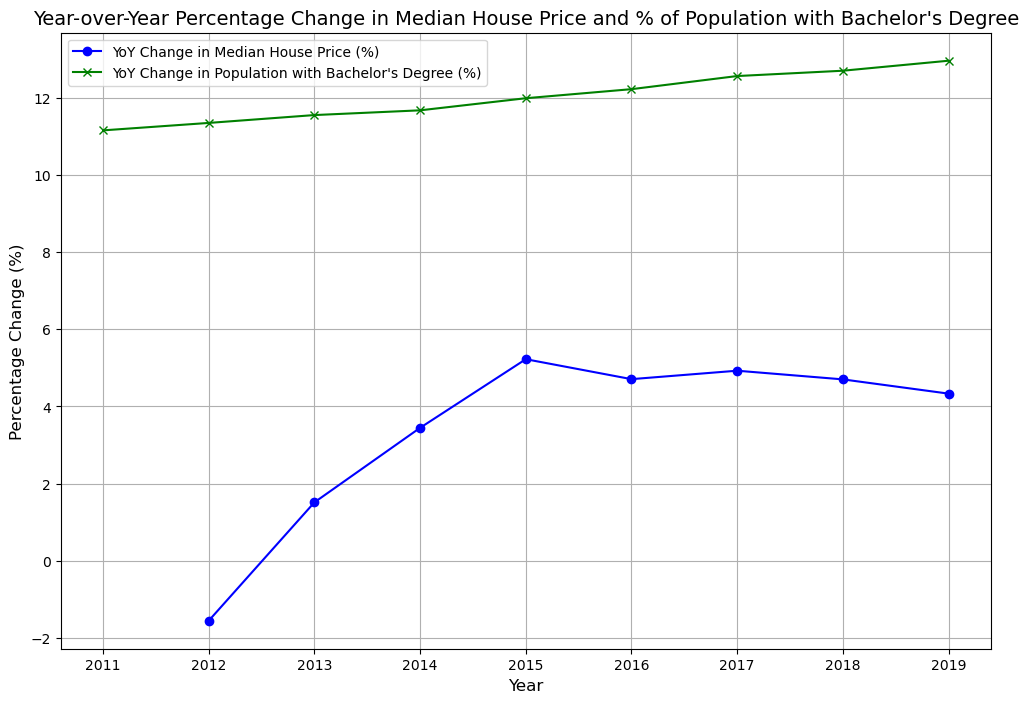

In [29]:
#LET'S SEE HOW PRICES AND EDUCATION HAVE CHANGED OVER TIME

# Step 1: Calculate the YoY percentage change for Median House Price
average_house_price_per_year = clean_data_df.groupby('Year')['Median House Price ($)'].mean()
house_price_pct_change = average_house_price_per_year.pct_change().dropna() * 100  # Percentage change

edu_pct_change = clean_data_df.groupby('Year')['% Pop. Bachelors Degree'].mean()


# Step 3: Plotting both lines on the same graph
plt.figure(figsize=(12, 8))

# Plot Median House Price YoY Percentage Change
plt.plot(house_price_pct_change.index, house_price_pct_change, label='YoY Change in Median House Price (%)', color='b', marker='o')

# Plot Population with Bachelor's Degree YoY Percentage Change
plt.plot(edu_pct_change.index, edu_pct_change, label="YoY Change in Population with Bachelor's Degree (%)", color='g', marker='x')

# Add labels and title
plt.title('Year-over-Year Percentage Change in Median House Price and % of Population with Bachelor\'s Degree', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Percentage Change (%)', fontsize=12)

# Add a legend to distinguish between the two lines
plt.legend()

# Display gridlines for clarity
plt.grid(True)

# Show the plot
plt.show()

In [31]:
#PERFORM A T-TEST ON THE DIFFERENCE BETWEEN MEAN HOUSE PRICES FOR TOP AND BOTTOM COUNTIES
#THIS USES ALL YEARS AND WILL CHANGE ONCE DAT IS FIXED
#note the median makes more sense for house prices given right skew
#any way to plot/visualize this?

# Step 1: Group by 'County Name' and 'Combined FIPS', and calculate average values for educational attainment and median house price
grouped_df = clean_data_df.groupby(['County Name', 'Combined FIPS']).agg(
    avg_bachelor_degree=('% Pop. Bachelors Degree', 'mean'),
    avg_median_house_price=('Median House Price ($)', 'median')
).reset_index()

# Step 2: Sort by educational attainment and select top 20% and bottom 20% counties
top_edu_counties = grouped_df.nlargest(int(len(grouped_df) * 0.25), 'avg_bachelor_degree')
bottom_edu_counties = grouped_df.nsmallest(int(len(grouped_df) * 0.25), 'avg_bachelor_degree')

# Step 3: T-test on the Median House Price for top and bottom educational attainment counties
# Extract the median house prices for each group
top_edu_prices = top_edu_counties['avg_median_house_price']
bottom_edu_prices = bottom_edu_counties['avg_median_house_price']

# Perform t-test
t_stat, p_value = stats.ttest_ind(top_edu_prices, bottom_edu_prices)

# Output the result
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Check if the p-value is less than 0.05 to conclude if there's a significant difference
if p_value < 0.05:
    print("There is a significant difference in median house prices between top and bottom educational attainment counties.")
else:
    print("There is no significant difference in median house prices between top and bottom educational attainment counties.")

T-statistic: 15.76392606893622
P-value: 2.8512205452456446e-44
There is a significant difference in median house prices between top and bottom educational attainment counties.


C:\Users\jitra\AppData\Local\Temp\ipykernel_21124\2153001631.py:22: DeprecationWarning: Please import `ttest_ind` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  t_stat, p_value = stats.ttest_ind(top_edu_prices, bottom_edu_prices)


STEP 7 - Insights & Reporting
Summarize findings, focusing on:
Strength and direction of correlation.
Patterns over time and across counties.
Results of hypothesis tests.
Highlight key takeaways:
Are counties with higher educational attainment significantly correlated with higher house prices?
Are there outliers or regions where the relationship deviates?
Discuss limitations (e.g., potential confounding variables or data coverage).